# Inverted Pendulum
**Objective**: To balance the pole (inverted pendulum) on top of the cart <br>

**Actions**: The agent takes a 1D vector for actions. The action space is a continuous `(action)` in `[-3, 3]`, where action represents the numerical force applied to the cart (with magnitude representing the amount of force and sign representing the direction) <br>

**Approach**: We use PyTorch to code REINFORCE from scratch to train a Neural Network policy to master inverted pendulum.

In [1]:
from __future__ import annotations

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

import gymnasium as gym

plt.rcParams["figure.figsize"] = (10, 5)

## Policy Network
We start by building a policy that the agent will learn using REINFORCE. A policy is a mapping from the current environment observation to a probability distribution of the actions to be taken. The policy used in the tutorial is parameterised by a neural network. It consists of 2 linear layers that are shared between both the predicted mean and standard deviation. Further, the single individual linear layers are used to estimate the mean and the standard deviation. `nn.Tanh` is used as a non-linearity between the hidden layers. The following function estimates a mean and standard deviation of a normal distribution from which an action is sampled. Hence it is expected for the policy to learn appropriate weights to output means and standard deviation based on the current observation.

In [2]:
class Policy_Network(nn.Module):
    """Parameterised Policy Network"""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initialises a neural network that estimates the mean and standard deviation of a normal distribution from which an 
        action is sampled from.
        
        Args:
            obs_space_dims: dimension of the observation space
            action_space_dims: dimension of the action space
        """
        super().__init__()

        hidden_space1 = 16
        hidden_space2 = 32

        # shared network
        self.shared_net = nn.Sequential(
            nn.Linear(obs_space_dims, hidden_space1),
            nn.Tanh(),
            nn.Linear(hidden_space1, hidden_space2),
            nn.Tanh()
        )

        # policy mean specific linear layer
        self.policy_mean_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

        # policy std speific linear layer
        self.policy_stddev_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )
    
    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Conditioned on the observation, returns the mean and standard deviation of a normal distribution from which
        an action is sampled from.
        
        Args:
            x: observation from the environment
        
        Returns:
            action_means: predicted mean of the normal distribution
            action_stddevs: predicted standard deviation of the normal distribution
        """
        shared_features = self.shared_net(x.float())

        action_means = self.policy_mean_net(shared_features)
        action_stddevs = torch.log(
            1 + torch.exp(self.policy_stddev_net(shared_features))
        )

        return action_means, action_stddevs

## Building an agent
REINFORCE: Reward Increment Non-negative Factor times Offset Reinforcement times Characteristic Eligibility

In [5]:
class REINFORCE:
    """REINFORCE algorithm"""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initialises an agent that learns a policy via REINFORCE algorithm.
        
        Args:
            obs_space_dims: dimension of the observation space
            action_space_dims: dimension of the action space
        """

        # Hyperparameters
        self.learning_rate = 1e-4  # learning rate for policy optimisation
        self.gamma = 0.99  # discount factor
        self.eps = 1e-6  # small number for mathematical stability

        self.probs = []  # stores probability values of the sampled action
        self.rewards = []  # stores the corresponding rewards

        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        """Returns an action, conditioned on the policy and observation.
        
        Args:
            state: observation from the environment

        Returns:
            action: action to be performed
        """
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.net(state)

        # create a normal distribution from the predicted mean and standard deviation and sample an action
        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()
        prob = distrib.log_prob(action)

        action = action.numpy()

        self.probs.append(prob)

        return action
    
    def update(self):
        """Updates the policy network's weights"""
        running_g = 0
        gs = []

        # discounted return (backwards) - [::-1] will return an array in reverse
        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)
        
        deltas = torch.tensor(gs)

        loss = 0
        # minimise -1 * prob * reward obtained
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        # update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # empty/zero out all episode-centric/related variables
        self.probs = []
        self.rewards = []

### Training procedure
    for seed in random seeds
        reinitialise agent 
        for episode in range of max numbers of episodes
            until episode is done
                sample action based on current observation
                take action and receive reward and next observation
                store action taken, its probability, and the observed reward
            update the policy

Note: Deep RL is fairly brittle concerning random seed in a lot of common use cases. Hence it is important to test out various seeds.

In [6]:
# create and wrap the environment
env = gym.make("InvertedPendulum-v4")
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # records episode-reward

total_num_episodes = int(5e3)  # total number of episodes
# observation-space of InvertedPendulum-v4 (4)
obs_space_dims = env.observation_space.shape[0]
# action-space of InvertedPendulum-v4 (1)
action_space_dims = env.action_space.shape[0]
rewards_over_seeds = []

for seed in [1, 2, 3, 5, 8]:  # Fibonacci seeds
    # set seed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # reinitialise agent every seed
    agent = REINFORCE(obs_space_dims, action_space_dims)
    rewards_over_episodes = []

    for episode in range(total_num_episodes):
        # gymnasium v26 requires users to set seed while resetting the environment
        obs, info = wrapped_env.reset(seed=seed)

        done = False
        while not done:
            action = agent.sample_action(obs)

            # step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
            # these represent the next observation, the reward from the step, if the episode is terminated, if the episode is truncated and
            # additional info from the step
            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            agent.rewards.append(reward)

            # end the episode when either truncated or terminated is true
            # - truncated: the episode duration reaches max number of timesteps
            # - terminated: any of the state space values is no longer finite
            done = terminated or truncated
        
        rewards_over_episodes.append(wrapped_env.return_queue[-1])
        agent.update()

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue[-1]))
            print("Episode:", episode, "Average Reward:", avg_reward)
    
    rewards_over_seeds.append(rewards_over_episodes)

Episode: 0 Average Reward: 8
Episode: 1000 Average Reward: 91
Episode: 2000 Average Reward: 108
Episode: 3000 Average Reward: 156
Episode: 4000 Average Reward: 162
Episode: 0 Average Reward: 18
Episode: 1000 Average Reward: 15
Episode: 2000 Average Reward: 54
Episode: 3000 Average Reward: 140
Episode: 4000 Average Reward: 155
Episode: 0 Average Reward: 4
Episode: 1000 Average Reward: 11
Episode: 2000 Average Reward: 46
Episode: 3000 Average Reward: 292
Episode: 4000 Average Reward: 1000
Episode: 0 Average Reward: 5
Episode: 1000 Average Reward: 41
Episode: 2000 Average Reward: 45
Episode: 3000 Average Reward: 164
Episode: 4000 Average Reward: 344
Episode: 0 Average Reward: 10
Episode: 1000 Average Reward: 29
Episode: 2000 Average Reward: 91
Episode: 3000 Average Reward: 91
Episode: 4000 Average Reward: 173


## Plot learning curve

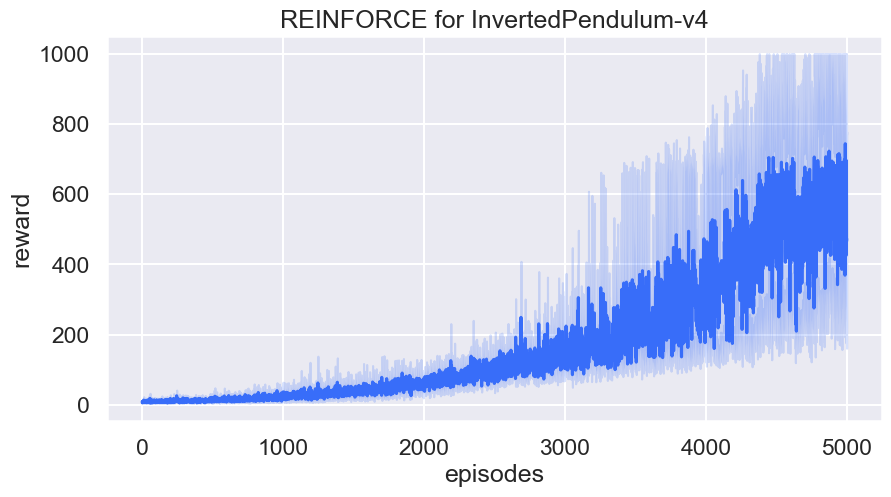

In [7]:
rewards_to_plot = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds]
df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(title="REINFORCE for InvertedPendulum-v4")
plt.show()